In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: ScriptNet
# ----------------------------
def build_scriptnet(input_shape=(32, 32, 1), num_classes=10):
    inputs = Input(shape=input_shape, name='input_layer')

    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax', name='output_layer')(x)

    model = Model(inputs=inputs, outputs=outputs, name='ScriptNet')
    return model

2025-06-10 17:17:22.857424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749575843.053338      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749575843.113050      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ----------------------------
# 2. Split datasets: 70% train, 15% validation, 15% test
# ----------------------------

import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

source_dir = "/kaggle/input/bangla-lekha-isolated-dataset/BanglaLekha-Isolated/Images-10classes"
base_output_dir = "/kaggle/working/banglalekha_split"
output_dirs = {
    'train': os.path.join(base_output_dir, 'train'),
    'val': os.path.join(base_output_dir, 'val'),
    'test': os.path.join(base_output_dir, 'test')
}

# Make sure output directories exist
for split_dir in output_dirs.values():
    os.makedirs(split_dir, exist_ok=True)

# Go through each class folder and split its contents
for class_name in os.listdir(source_dir):
    class_dir = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = os.listdir(class_dir)
    images = [img for img in images if img.endswith(".png") or img.endswith(".jpg")]

    # Split 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_class_dir = os.path.join(output_dirs[split], class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_dir, img), os.path.join(split_class_dir, img))


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 50
num_classes = 10  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/banglalekha_split/train"
val_path   = "/kaggle/working/banglalekha_split/val"
test_path  = "/kaggle/working/banglalekha_split/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)


Found 13856 images belonging to 10 classes.
Found 2970 images belonging to 10 classes.
Found 2975 images belonging to 10 classes.


In [4]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749576057.559901      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749576057.560684      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,476,298 (9.45 MB)

 Trainable params: 2,474,378 (9.44 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("scriptnet_Bangla10Classes_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs=60

In [6]:
# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749576073.951125     120 service.cc:148] XLA service 0x7e10e0009900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749576073.951915     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749576073.951941     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749576074.439087     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/217 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1619 - loss: 2.6720 

I0000 00:00:1749576080.066336     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5512 - loss: 1.2896
Epoch 1: val_accuracy improved from -inf to 0.10505, saving model to scriptnet_Bangla10Classes_best.h5
217/217 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.5518 - loss: 1.2879 - val_accuracy: 0.1051 - val_loss: 2.8086 - learning_rate: 0.0010
Epoch 2/60
216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8247 - loss: 0.5022
Epoch 2: val_accuracy improved from 0.10505 to 0.56364, saving model to scriptnet_Bangla10Classes_best.h5
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8248 - loss: 0.5019 - val_accuracy: 0.5636 - val_loss: 1.1688 - learning_rate: 0.0010
Epoch 3/60
216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8660 - loss: 0.3900
Epoch 3: val_accuracy improved from 0.56364 to 0.93771, saving model to scriptnet_Bangla10Classes_best.h5
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8660 - loss: 0.3899 - val_accuracy: 0.9377 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 

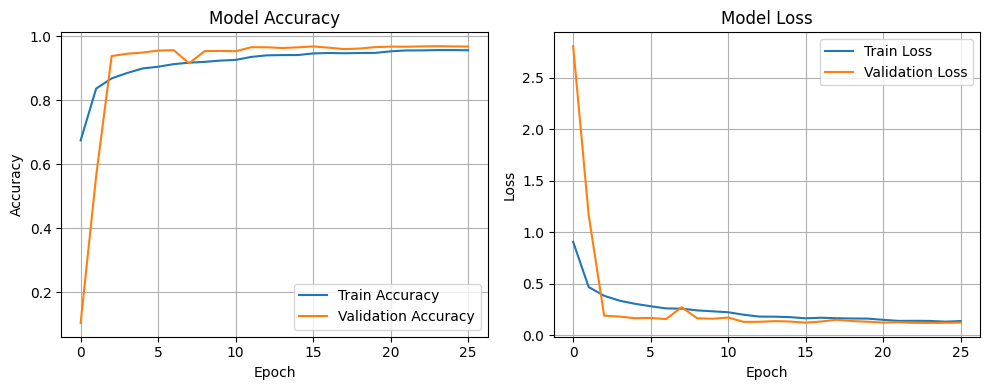

In [7]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


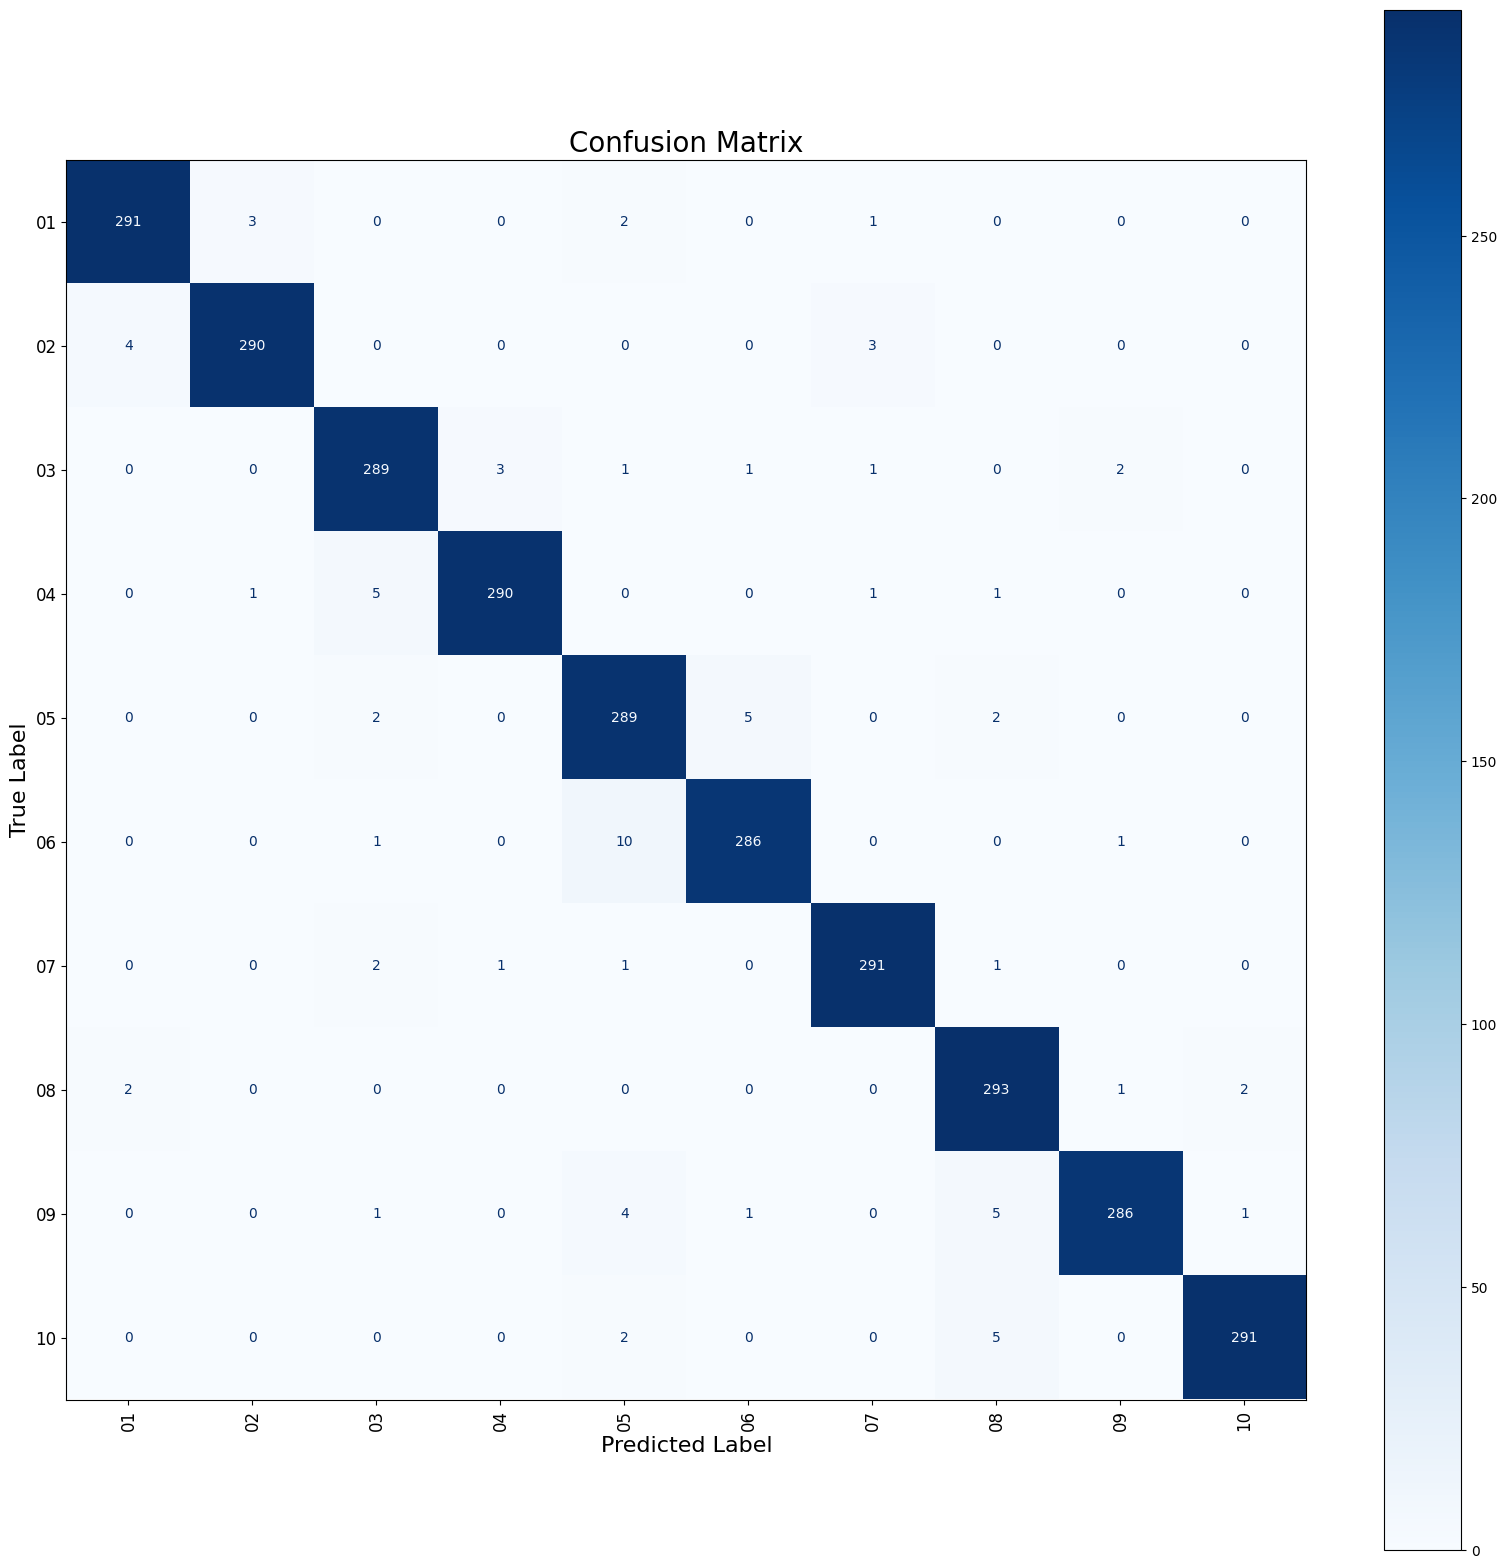

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes for visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.show()


In [9]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
📋 Classification Report:

              precision    recall  f1-score   support

          01     0.9798    0.9798    0.9798       297
          02     0.9864    0.9764    0.9814       297
          03     0.9633    0.9731    0.9682       297
          04     0.9864    0.9732    0.9797       298
          05     0.9353    0.9698    0.9522       298
          06     0.9761    0.9597    0.9679       298
          07     0.9798    0.9831    0.9815       296
          08     0.9544    0.9832    0.9686       298
          09     0.9862    0.9597    0.9728       298
          10     0.9898    0.9765    0.9831       298

    accuracy                         0.9734      2975
   macro avg     0.9738    0.9735    0.9735      2975
weighted avg     0.9737    0.9734    0.9735      2975

🔢 Macro Scores
Precision (Macro): 0.9738
Recall (Macro):    0.9735
F1-score (Macro):  0.9735

🔢 Weighted Scores
Precision (Weighted): 0.9737
Recall (Weighted):    0.9734
F1-sc